<img src='sharif_logo.png' alt="SUT logo" width=150 height=150 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Computer Engineering Department - Spring 2025  <br>
<font color=3C99D size=5>
          Homework 3: Practical - GPT2 from Scratch! <br>
<font color=696880 size=4>
            Designer: Shaygan Adim
    
    

**Name**:  AmirHossein Haji Mohammad Rezaei
  
**Student Code**: 99109252

# Overview

In this project, you will implement a scaled-down version of OpenAI's GPT-2 architecture from scratch using PyTorch. You'll train this model on the Snappfood comments with sentiment labels. The goal is to create a generative language model that can produce synthetic Persian comments with controllable sentiment (positive or negative).

# Learning Objectives

* Understanding and implementing transformer-based language model architectures  
* Learning how to control text generation using special tokens  
* Visualizing and analyzing training progress  

# Dataset

You'll work with a Persian dataset containing Snappfood comments:  

* The dataset texts are normalized (No need for any normalizations)
* Each comment has a sentiment label (1 for positive, 0 for negative)
* The dataset contains text with variations in length and style

# Tokenizer and model

You should use one of the sota open-source LLM tokenizers. I strongly recommend using Llama 3.3 tokenizer or Gemma-2 tokenizer as they're better than the others in Persian language. (There is no need to implement a tokenizer yourself.)

Your model should have the exact srtructure of GPT-2:  
  
<img src="GPT-2.png" alt="" width="600" height="800">
  
For the model to be able to smoothly be trained, you should use the config below:

* **Embedding Dimension**: 192 (reduced from 768 in original GPT-2)
* **Layers**: 3 transformer blocks (reduced from 12 in original GPT-2)
* **Attention Heads**: 3 (reduced from 12 in original GPT-2)
* **Context Window**: 128 tokens (reduced from 1024 in original GPT-2)

Moreover, unlike the original Transformer paper that used fixed sinusoidal position encodings, GPT-2 (and your implementation) should use learnable position embeddings:
1. You should create an embedding table of size [n_positions, n_embd] where:

    * n_positions is the maximum sequence length (128 in our model)
    * n_embd is the embedding dimension (192 in our model)
2. For each position in the sequence (0 to sequence_length-1), we look up the corresponding embedding vector.

3. These position embeddings are added to the token embeddings before being passed through the transformer blocks.

# Some notes:

* Be aware that you will be questioned about your solution to this assignment in-person. Thus, build a solid understanding through out solving this assignment.
* Using ChatGPT and other LLMs are allowed but you should be able to explain every line of your code completely.
* You need GPU for this assignment. Use can use Colab or Kaggle for free.
* I highly recommend using the exact same structure and instructions that is provided for you in the notebook but minor changes will be tolerated.
* Read the whole notebook once before coding. It will give you a broad vision about what you should do on the whole.
* Instructions provided for you in TODO sections ARE NOT the only things that you should do in those parts. They're just some important bullet points that your code should have.
* The final results (Inference section) should have the minimum quality of the samples already generated in the notebook.

# Importing

In [1]:
# Data loading and manipulation
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Tokenization utilities
from transformers import AutoTokenizer
from huggingface_hub import login

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Visualization tool
import matplotlib.pyplot as plt

# Runtime utilities
import math
import time
from tqdm import tqdm

# Typing tool
from typing import Dict, Optional, Any

# Downloading and loading the data

In this section we read and load the data from [here](https://www.kaggle.com/datasets/mohammad1ziyar/cleaned-snappfood-persian-sentiment-analysis).

You can also see some information about the data in the next cell. In the end, we only want the label and cleaned columns.

In [2]:
from kagglehub import KaggleDatasetAdapter
raw_corpus = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "mohammad1ziyar/cleaned-snappfood-persian-sentiment-analysis",
    "cleaned_snappfood.csv",
)

In [3]:
# TODO: Download the dataset using kagglehub

path = '/kaggle/input/cleaned-snappfood-persian-sentiment-analysis'

print("Path to dataset files:", path)

raw_corpus = pd.read_csv(path + "/cleaned_snappfood.csv")

Path to dataset files: /kaggle/input/cleaned-snappfood-persian-sentiment-analysis


In [4]:
raw_corpus.info()
raw_corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65973 entries, 0 to 65972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          65973 non-null  object
 1   label            65973 non-null  int64 
 2   comment_length   65973 non-null  int64 
 3   comment_cleaned  65973 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


,comment,label,comment_length,comment_cleaned
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,0,47,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,1,132,قرار بود ساعته برسه ولی نیم ساعت زودتر از موق...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,0,89,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3,عالی بود همه چه درست و به اندازه و کیفیت خوب، ...,1,99,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...
4,شیرینی وانیلی فقط یک مدل بود.,1,29,شیرینی وانیلی فقط یک مدل بود


In [5]:
raw_corpus = raw_corpus[["comment_cleaned", "label"]]

# Downloading and loading the tokenizer (5 Points)

In this section you need to load your tokenizer from hugging face. I recommend [this](https://huggingface.co/meta-llama/Llama-3.3-70B-Instruct) or [this](https://huggingface.co/google/gemma-2-27b-it).
Keep in mind that you might need to login first using your hugging face access token and also sign an agreement thing in model's page to be able to access the model and it's tokenizer.

In [ ]:
login(token="")

In [7]:
# TODO: Set up authentication (if needed) and initialize a tokenizer
#  Use the login() function to authenticate with your Hugging Face token (if needed)
#  Initialize a tokenizer using the AutoTokenizer class

tokenizer = AutoTokenizer.from_pretrained('google/gemma-2-27b-it')

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In the cell below, add two special tokens to the vocabulary of the tokenizer indicating positivity or negativity of a comment. We will add these tokens manually as the first token of each comment so model will understand the difference between positive and negative comments.

In [8]:
# TODO: Add custom special tokens to the tokenizer

# 1. Create a dictionary named 'special_tokens' with a key 'additional_special_tokens' that contains a list of two special tokens for positivity and negativity
# 2. Add these tokens to the vocabulary

# These special tokens will be used to tell the model what sentiment we're expecting during training and inference.

special_tokens = {'additional_special_tokens': ['<POS>', '<NEG>']}
tokenizer.add_special_tokens(special_tokens)

2

## Dataset and Dataloader (10 Points)

Create a custom Dataset class for the data

In [9]:
class CommentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        # self.tokenizer.pad_token = self.tokenizer.bos_token
        self.comments = dataframe['comment_cleaned'].tolist()
        self.labels = dataframe['label'].tolist()
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.comments)

    def __getitem__(self, idx: int) -> dict:
        # TODO: Process a single item from the dataset
        # This method should:
        # 1. Get the appropriate label and comment at the given index
        # 2. Create a prefix based on the sentiment
        # 3. Tokenize the text

        label = self.labels[idx]
        sentiment = '<POS>' if label == 1 else '<NEG>'
        comment = sentiment + self.comments[idx]

        encoded_batch = tokenizer(
            comment,
            max_length = self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoded_batch['input_ids'].squeeze(0)
        attention_mask = encoded_batch['attention_mask']
        labels = input_ids.clone()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

Create train and validation datasets and dataloaders and also split the data

In [10]:
# TODO: Prepare the training and validation datasets and dataloaders
#
# 1. Split the raw_corpus dataframe into training and validation sets with a suitable ratio
# 2. Create dataset instances using the CommentDataset class:
# 3. Create DataLoader instances

train_df, val_df = train_test_split(raw_corpus, test_size=0.2, random_state=42)

train_dataset = CommentDataset(train_df, tokenizer)
val_dataset = CommentDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

## Model implementation (35 Points)

In this section you should implement the model architecture completely from scratch. No pre-defined torch or other libraries tools are allowed. (Even for the attention mechanism)

In [11]:
class GPT2Config:
    def __init__(
        self,
        vocab_size,
        n_positions,
        n_embd,
        n_layer,
        n_head,
        n_inner=None,
        activation_function="gelu",
        resid_pdrop=0.1,
        embd_pdrop=0.1,
        attn_pdrop=0.1,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        bos_token_id=None,
        eos_token_id=None,
        pad_token_id=None
    ):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_inner = 4 * n_embd if n_inner is None else n_inner
        self.activation_function = activation_function
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attn_pdrop = attn_pdrop
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id
        self.pad_token_id = pad_token_id



In [12]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.attn_pdrop

        self.head_dim = self.n_embd // self.n_head

        # TODO: Initialize the query, key, value projection layer
        # Create a single linear layer (c_attn) that projects the input embeddings to query, key, and value vectors
        # The output dimension should be 3 * config.n_embd
        self.c_attn = nn.Linear(self.n_embd, 3*self.n_embd)

        # TODO: Initialize the output projection layer
        # Create a linear layer (c_proj) that projects the attention output back to the embedding dimension
        self.c_proj = nn.Linear(self.n_embd, self.n_embd)

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)

        # TODO: Create the causal attention mask
        # Register a buffer named "mask" with shape (config.n_positions, config.n_positions)
        mask = torch.tril(torch.ones(config.n_positions, config.n_positions)).unsqueeze(0).unsqueeze(0)
        self.register_buffer('mask', mask)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality

        # TODO: Implement the multi-head attention mechanism
        # 1. Project input x to query, key, and value using self.c_attn
        qkv = self.c_attn(x) # B, T, 3 * C
        qkv = qkv.reshape((B, T, 3, self.n_head, self.head_dim)).permute(2, 0, 3, 1, 4) # 3, B, N, T, H
        q, k, v = qkv[0], qkv[1], qkv[2] # each: B, N, T, H

        # 2. Compute attention scores:
        attn_scores = q @ k.transpose(-2, -1) / (self.head_dim ** 0.5) # B, N, T, T
        attn_scores = attn_scores.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf')) # B, N, T, T
        attn_weights = torch.softmax(attn_scores, dim=-1) # B, N, T, T
        attn_weights = self.attn_dropout(attn_weights) # B, N, T, T

        # 3. Apply attention weights to values
        attn_outputs = attn_weights @ v # B, N, T, H
        # 4. Apply the output projection and residual dropout
        attn_outputs = attn_outputs.transpose(1, 2).reshape(B, T, C) # B, T, C
        y = self.c_proj(attn_outputs)
        y = self.resid_dropout(y)
        return y

In [13]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, config.n_inner)
        self.c_proj = nn.Linear(config.n_inner, config.n_embd)
        self.dropout = nn.Dropout(config.resid_pdrop)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement the feed-forward network forward pass
        y = self.c_proj(self.gelu(self.c_fc(x)))
        z = self.dropout(y)
        return z

In [14]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Initialize the components of a transformer block
        self.norm1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        self.norm2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)

        self.attention = CausalSelfAttention(config)
        self.mlp = MLP(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement the transformer block forward pass with residual connections
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [15]:
class GPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(config.vocab_size, config.n_embd),
            'wpe': nn.Embedding(config.n_positions, config.n_embd),
            'drop': nn.Dropout(config.embd_pdrop),
            'h': nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            'ln_f': nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
        })

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer['wte'].weight = self.lm_head.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):
        # TODO: Implement the weight initialization function
        # 1. For Linear and Embedding layers:
        #    - Initialize weights from a normal distribution with mean=0.0 and
        #      std=self.config.initializer_range
        #    - For Linear layers with bias, initialize the bias to zero
        # 2. For LayerNorm layers:
        #    - Initialize bias to zero
        #    - Initialize weight to ones

        if isinstance(module, nn.Linear):
          nn.init.normal_(module.weight, mean=0, std=self.config.initializer_range)
          if module.bias is not None:
            nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
          nn.init.zeros_(module.bias)
          nn.init.ones_(module.weight)
        elif isinstance(module, nn.Embedding):
          nn.init.normal_(module.weight, mean=0, std=self.config.initializer_range)


    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        # TODO: Implement the forward pass
        #
        # 1. Create position indices
        # 2. Compute embeddings
        # 3. Process the input through transformer blocks
        # 4. Apply final layer normalization
        # 5. Compute logits using the language model head
        # 6. Return a dictionary with 'logits' and 'loss' (if calculated)
        B, T = input_ids.shape

        position_ids = torch.arange(0, T, dtype=torch.long, device=input_ids.device).unsqueeze(0).expand(B, T)

        token_emb = self.transformer['wte'](input_ids)
        position_emb = self.transformer['wpe'](position_ids)
        emb = self.transformer['drop'](token_emb + position_emb)

        for block in self.transformer['h']:
          emb = block(emb)

        emb = self.transformer['ln_f'](emb)
        logits = self.lm_head(emb) # B, T, V

        loss=None
        if labels is not None:
          target_ids = labels[:, 1:].reshape(-1) # B*(T-1)
          target_logits = logits[:, :-1, :].reshape((-1, logits.shape[-1])) # B*(T-1), V
          # loss = F.cross_entropy(target_logits, target_ids)
          loss_fn = nn.CrossEntropyLoss(ignore_index=self.config.pad_token_id)
          loss = loss_fn(target_logits, target_ids)
          
        return {'logits': logits, 'loss': loss}

    
    def generate(self, input_ids: torch.Tensor, max_length: int,
                temperature: float = 1.0, top_k: int = 0, top_p: float = 0.9) -> torch.Tensor:
        # TODO: Implement text generation with various decoding strategies
        # This method should generate text auto-regressively using the trained model
        # with temperature, top-k, and nucleus (top-p) sampling techniques.
        #
        # 1. Set the model to evaluation mode
        # 2. Loop to generate 'max_length' new tokens:
        #    a. Run the forward pass to get logits for the current sequence
        #    b. Extract logits for the last token and apply temperature scaling        #
        #    c. Apply top-k sampling if top_k > 0:
        #    d. Apply nucleus (top-p) sampling if top_p < 1.0:
        # 3. Return the complete generated sequence

        self.eval()

        with torch.no_grad():
          for _ in range(max_length):
            # print(input_ids)
            # print('******')
            # ids = input_ids[:, -self.config.n_positions:] # B, T
            outputs = self.forward(input_ids) # 1, T, C
            logits = outputs['logits'][:, -1, :] / temperature # 1, C

            if top_k > 1:
              remove_indices = logits < torch.topk(logits, top_k)[0][:, -1, None]
              logits[remove_indices] = float('-inf')

            if top_p < 1.0:
              sorted_logits, sorted_indices = torch.sort(logits, descending=True)
              probs_cumsum = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

              indices_to_remove = probs_cumsum > top_p
              indices_to_remove[:, 1:] = indices_to_remove[:, :-1].clone()
              indices_to_remove[:, 0] = 0

              sorted_logits[indices_to_remove] = float('-inf')
              logits = torch.gather(sorted_logits, 1, sorted_indices.argsort(-1))

            pred_token = torch.multinomial(torch.softmax(logits, dim=-1), 1) # 1, 1
            input_ids = torch.cat((input_ids, pred_token), dim=1) # 1, T+1

        self.train()
        return input_ids

In [16]:
config = GPT2Config(
    vocab_size=len(tokenizer),
    n_positions=128,
    n_embd=192,
    n_layer=3,
    n_head=3,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GPT2(config)
model.to(device)
# model.load_state_dict(torch.load('/content/model.pt'))

GPT2(
  (transformer): ModuleDict(
    (wte): Embedding(256002, 192)
    (wpe): Embedding(128, 192)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attention): CausalSelfAttention(
          (c_attn): Linear(in_features=192, out_features=576, bias=True)
          (c_proj): Linear(in_features=192, out_features=192, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (mlp): MLP(
          (c_fc): Linear(in_features=192, out_features=768, bias=True)
          (c_proj): Linear(in_features=768, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (gelu): GELU(approximate='none')
        )
      )
    )
    (ln_f): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (lm_he

## Train and evaluation (25 Points)

Now you should implement the train and evaluation functions.

In [17]:
def train_epoch(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer,
               scheduler, device: torch.device, log_interval: int) -> tuple:
    # TODO: Implement the training loop for a single epoch

    total_loss = 0.0
    step_nums = []
    step_losses = []

    model.train()
    with tqdm(enumerate(data_loader), total=len(data_loader)) as pbar:
      for step, batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
          scheduler.step()

        total_loss += loss.item()
        if step % log_interval == 0:
          step_nums.append(step)
          step_losses.append(loss.item())


    return total_loss / len(data_loader), step_nums, step_losses

def evaluate(model: nn.Module, data_loader: DataLoader,
            device: torch.device, log_interval: int) -> tuple:
    # TODO: Implement the evaluation loop
    total_loss = 0.0
    step_nums = []
    step_losses = []

    model.eval()
    with tqdm(enumerate(data_loader), total=len(data_loader)) as pbar:
      for step, batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs['loss']

        total_loss += loss.item()
        if step % log_interval == 0:
          step_nums.append(step)
          step_losses.append(loss.item())
    return total_loss / len(data_loader), step_nums, step_losses

Now train the model for 3 to 5 epochs. It's recommended to use a suitable learning rate scheduler (For example, cosine). Also save training and validation loss periodically.

In [18]:
# TODO: Set up and run the training loop

# Implement the main training loop:
#    For each epoch:
#       - Call train_epoch to train for one epoch and get losses and step information
#       - Store the average epoch loss in epoch_train_losses
#       - Update step tracking, adjusting step numbers for the current epoch
#       - Call evaluate to validate the model and get validation losses
#       - Store the average validation loss in epoch_val_losses
#       - Update validation step tracking
#       - Print the training and validation losses for the epoch

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

epochs = 5

optimizer = Adam(model.parameters(), lr=1e-4)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

all_epochs = []
epoch_train_losses = []
epoch_val_losses = []
all_train_step_losses = []
all_train_step_nums = []
all_val_step_losses = []
all_val_step_nums = []

best_val_loss = float('inf')

train_step_offset = 0
val_step_offset = 0
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # --- Training ---
    train_loss, train_step_nums, train_step_losses = train_epoch(
        model, train_loader, optimizer, scheduler, device, log_interval=100
    )

    epoch_train_losses.append(train_loss)
    # Offset step numbers for epoch continuity
    train_step_nums = [step + train_step_offset for step in train_step_nums]
    all_train_step_nums.extend(train_step_nums)
    all_train_step_losses.extend(train_step_losses)
    train_step_offset += len(train_loader)

    # --- Evaluation ---
    val_loss, val_step_nums, val_step_losses = evaluate(
        model, val_loader, device, log_interval=100
    )

    epoch_val_losses.append(val_loss)
    val_step_nums = [step + val_step_offset for step in val_step_nums]
    all_val_step_nums.extend(val_step_nums)
    all_val_step_losses.extend(val_step_losses)
    val_step_offset += len(val_loader)

    # --- Print losses ---
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    all_epochs.append(epoch + 1)
    # --- Update best model ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")



Epoch 1/5


100%|██████████| 2639/2639 [01:37<00:00, 27.10it/s]


Epoch 1 - Train Loss: 4.7267, Val Loss: 3.8156

Epoch 2/5


100%|██████████| 2639/2639 [01:37<00:00, 27.05it/s]


Epoch 2 - Train Loss: 3.6739, Val Loss: 3.4910

Epoch 3/5


100%|██████████| 2639/2639 [01:37<00:00, 27.04it/s]


Epoch 3 - Train Loss: 3.4405, Val Loss: 3.3296

Epoch 4/5


100%|██████████| 2639/2639 [01:37<00:00, 26.98it/s]


Epoch 4 - Train Loss: 3.3059, Val Loss: 3.2287

Epoch 5/5


100%|██████████| 2639/2639 [01:37<00:00, 26.96it/s]


Epoch 5 - Train Loss: 3.2109, Val Loss: 3.1562


Plot the training and validation loss in each epoch and also in each steps you saved before.

# Inference (15 Points)

Complete the function below to generate comments (positive or negative)

In [19]:
def generate_comment(model: nn.Module, tokenizer: Any, sentiment: str, max_length: int = 50) -> str:
    # TODO: Implement text generation with sentiment control
    # 1. Create the appropriate prefix based on the sentiment parameter
    # 2. Generate text using the model's generate method

    prompt = '<POS>' if sentiment == 'positive' else '<NEG>'

    input = tokenizer(prompt, return_tensors="pt").to(device)
    # print(input['input_ids'])

    output_ids = model.generate(input['input_ids'], max_length, top_p=0.8, top_k=100, temperature=0.5)
    # print(output_ids)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

In [20]:
model.eval()
print('Negative Comment:')
print(generate_comment(model, tokenizer, 'negative'))

Negative Comment:
سلام تاخیر رسید غذا سرد بود و کاملا سرد بود و بیکیفیت بود و غذا به دستم رسید و کیفیت غذاها هم خیلی خوب بود و کیفیت غذاها هم بسیار خوب بود و کیفیت و این رستورانهای دیگه از رست


Generate 10 positive and 10 negative comments and evaluate your results

In [21]:
# TODO: Demonstrate the model's sentiment-controlled text generation

model.eval()

for _ in range(10):
  # a. Generate a positive comment using the generate_comment function:
  print('Positive Comment:')
  print(generate_comment(model, tokenizer, 'positive'))
  # b. Generate a negative comment using the generate_comment function:
  print('Negative Comment:')
  print(generate_comment(model, tokenizer, 'negative'))

Positive Comment:
سلام خیلی زود رسید و خیلی خوشمزه بود ممنونم ازتون و از اسنپ فود و اسنپ فود و اسنپ فود هم ازتون و اسنپ فود و اسنپ فود و اس
Negative Comment:
واقعا بد بود اصلا نمیشه ازشیمونم چرا این رستوران سفارش میدم این رستوران غذا سفارش میدم کیفیت غذا رو نداشتم این غذا بدم و واقعا این رستوران رو این رستوران واقعا متفم از این رست
Positive Comment:
واقعا عالی بود هم زود رسید هم داغ و گرم بود هم به دستم رسید هم داغ و هم به موقع رسید و هم رسید ممنونم ازتون که از اسنپ فود که به موقع بودیمون از شما که سفارش
Negative Comment:
بسته و بیکیفیت و بیکیفیت بود در سفارش نخواستم که سفارش داده بودم از شمام بدم این رستوران غذا رو به مشتری دائم این رستورانهای رستوران هستم از این رستوران هستم که این رست
Positive Comment:
غذا سرد بود و خیلی زود رسید و گرم بود ممنون از اسنپ فود و اسنپ فود و اسنپ فود و اسنپ فود که به موقع و اسنپ فود و اسنپ
Negative Comment:
واقعا افتضاح بود انگار از نون پیتزا نپخته بود و اصلا قابل خوردن نبود و ازش همبرگرنه بود واقعا از این رستوران راضی بودم این رستوران غذا از این رستوران

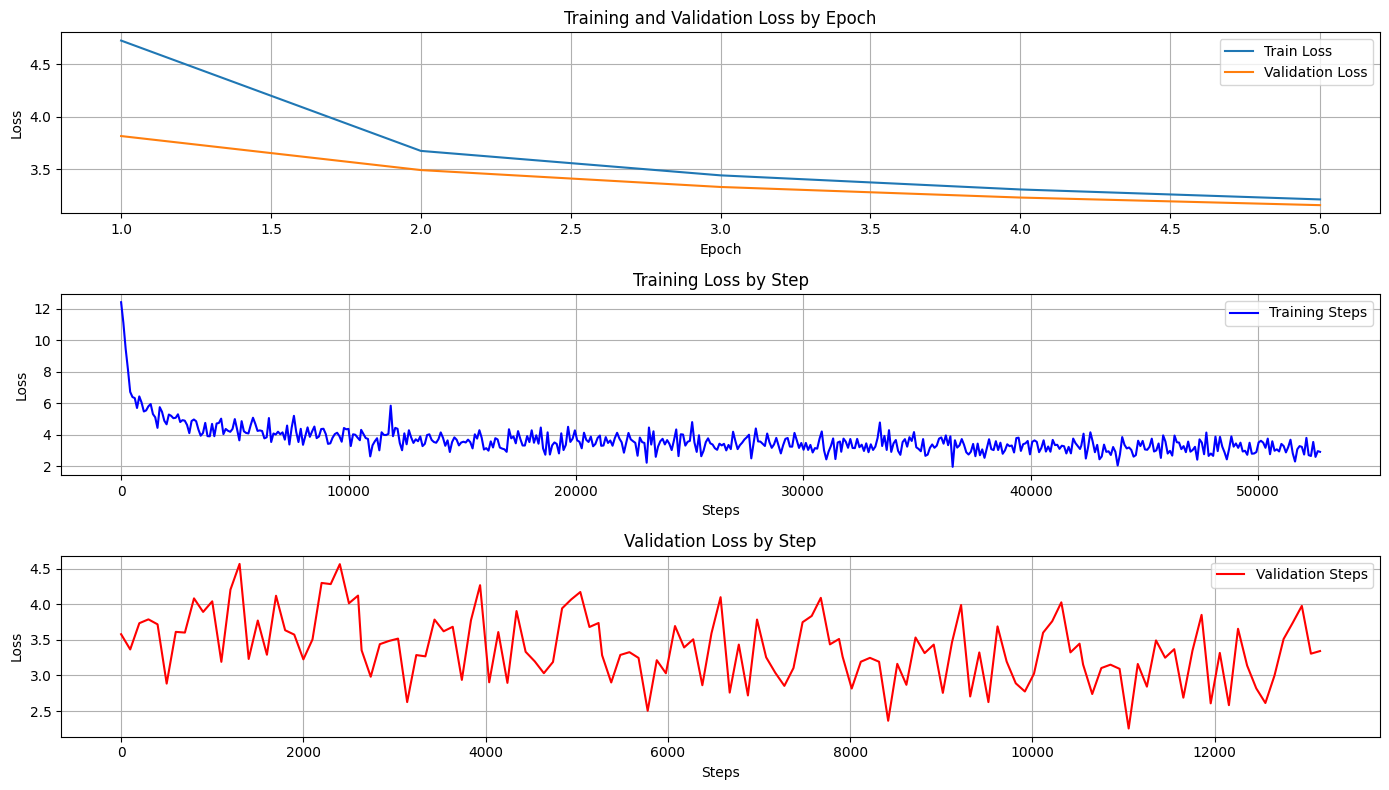

In [22]:
# TODO: Visualize the training and validation results

# Create three subplots:
#    a. Plot epoch-level training and validation losses
#    b. Plot step-level training losses
#    c. Plot step-level validation losses

import matplotlib.pyplot as plt

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=False)

# First subplot: Loss by Epoch
axs[0].plot(all_epochs, epoch_train_losses, label='Train Loss')
axs[0].plot(all_epochs, epoch_val_losses, label='Validation Loss')
axs[0].set_title('Training and Validation Loss by Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_axisbelow(True)

# Second subplot: Training Loss by Step
axs[1].plot(all_train_step_nums, all_train_step_losses, label='Training Steps', color='blue')
axs[1].set_title('Training Loss by Step')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].set_axisbelow(True)

# Third subplot: Validation Loss by Step
axs[2].plot(all_val_step_nums, all_val_step_losses, label='Validation Steps', color='red')
axs[2].set_title('Validation Loss by Step')
axs[2].set_xlabel('Steps')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)
axs[2].set_axisbelow(True)

plt.tight_layout()
plt.show()


## Inference Time Hyperparameters (10 Points)

Play with these parameters for the best results:
  
temperature, top_k, top_p

Briefly report what you saw and try to explain why is it happening. What is the effect of each one?

**Your Report**:  